# Comet Visibility 

This code is made to estimate the number of comets visible at IMPACTON per year by magnitud bins.

Visibility is being defined as if the comet reachs Altitud > 30 at least one day in the year.

For this calculation, we are getting the current comets list from the MPC

In [1]:
import requests
import re
from astroquery.mpc import MPC
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Getting the designations of known comets from MPC

In [2]:
def get_comets_ids(clean=True):
    # URL of the comet orbital elements file
    url = "https://www.minorplanetcenter.net/iau/MPCORB/CometEls.txt"
    # Download the file
    response = requests.get(url)
    response.raise_for_status()
    lines = response.text.splitlines()
    # Skip header (lines starting with `;`)
    data_lines = [line for line in lines if not line.startswith(';') and line.strip()]
    # Extract comet designation (between cols 102 and 158 characters)
    designations = [line[102:158].strip() for line in data_lines]
    if clean:
        # Remove the parentheses and contents
        designations = [re.sub(r'\s*\([^)]+\)', '', c) for c in designations]
    return designations

In [3]:
comets = get_comets_ids()
print(f"Number of comets: {len(comets)}")

Number of comets: 1199


## Estimating number of comets visible by magnitud bin

In [4]:
# Magnitud bins
mag_edges = [float('-inf'), 14, 15, 16, 17, 18]
labels = ['year', '<=14', '14–15', '15–16', '16–17', '17–18']
# Output definition
comets_impacton = pd.DataFrame(columns=labels)
comets_impacton = comets_impacton.set_index('year')
comets_impacton

,<=14,14–15,15–16,16–17,17–18
year,,,,,


In [5]:
def comets_per_year(year,
                    location = "Y28",  # Observatory code
                    number = 365, # One year
                    step = "1d", # per day
                    mag_edges=mag_edges, # output limits
                    output=comets_impacton # output table
                   ):
    # Observation date
    start = f"{year}-01-01" 
    # prepare output
    comet_bright = []
    comet_not_visible = []
    # Query ephemeris
    for comet in comets[:]:
        try:
            ephem = MPC.get_ephemeris(target=comet,
                                      location=location,
                                      start=start,
                                      number=number,
                                      step=step)
            # Selecting visible epochs 
            ephem = ephem[ephem['Altitude']>30]
            if len(ephem) > 1: 
                comet_bright.append(ephem['V'].max())
            else:
                comet_not_visible.append(comet)
        except:
            comet_not_visible.append(comet)
    # counting number of comets per bin of magnitude
    counts = np.histogram(comet_bright, bins=mag_edges)[0]
    output.loc[year] = counts


In [6]:
# Estimating the number of comets in the decade
for year in range(2020, 2030):
    comets_per_year(year)
    print(year)

comets_impacton

2020
2021
2022
2023
2024
2025
2026
2027
2028


/home/mario/local/anaconda3/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/mario/local/anaconda3/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/mario/local/anaconda3/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 365 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


2029


,<=14,14–15,15–16,16–17,17–18
year,,,,,
2020,0,4,7,10,29
2021,4,1,12,11,28
2022,7,6,5,11,22
2023,5,3,12,11,26
2024,6,4,4,7,28
2025,1,4,6,13,17
2026,1,3,1,6,23
2027,0,2,2,5,21
2028,1,3,8,6,19


## Plotting the comets visible at IMPACTON per year

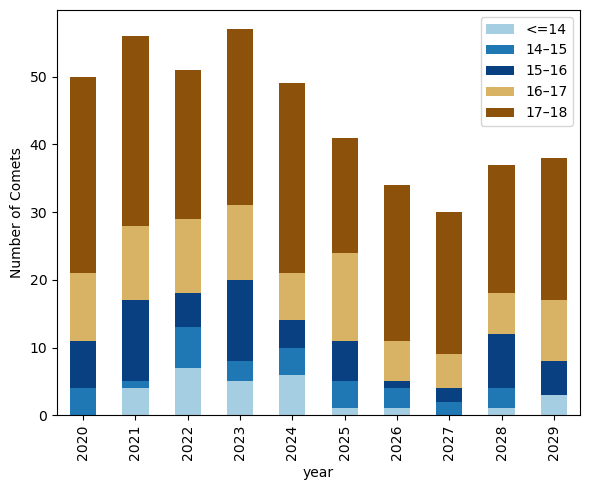

In [7]:
# Define colors
color_map = {
    '<=14':     '#a6cee3',
    '14–15':    '#1f78b4',
    '15–16':    '#084081',
    '16–17':    '#d8b365',
    '17–18':    '#8c510a',
    '>18':      '#543005',
}
colors = [color_map[col] for col in comets_impacton.columns]

comets_impacton.plot(kind='bar', stacked=True, color=colors, figsize=(6, 5))
plt.ylabel('Number of Comets')
plt.tight_layout()
plt.savefig('comets_impacton_year.png', dpi=200)
plt.show()